## We have our Series, our GroupBy, and our DataFrame.

We added comments to a usage example for our `phoenixcel` library so that our clients will understand how to use the different methods. Our usage example closely follows a homework problem that we completed during chapter 3 with the `csv` library.

Right now, our phoenixcel solution isn't really more concise or legible than the `csv` library. It's still in the 20-30 line range, and each individual command still doesn't communicate its _intent_ that well. 

**Now, the thing we're trying to do here is:**

1. Extract some data from somewhere
2. Perform some transformations on that data
3. Display some summary metrics about that data

What sort of programming approach is popular for solving a problem like that? A **functional** approach, of course!

In homework 6, you learned about an interface design option for functional programming: the **fluent interface**. What if we had a fluent interface for our `DataFrame` so that we could do this?

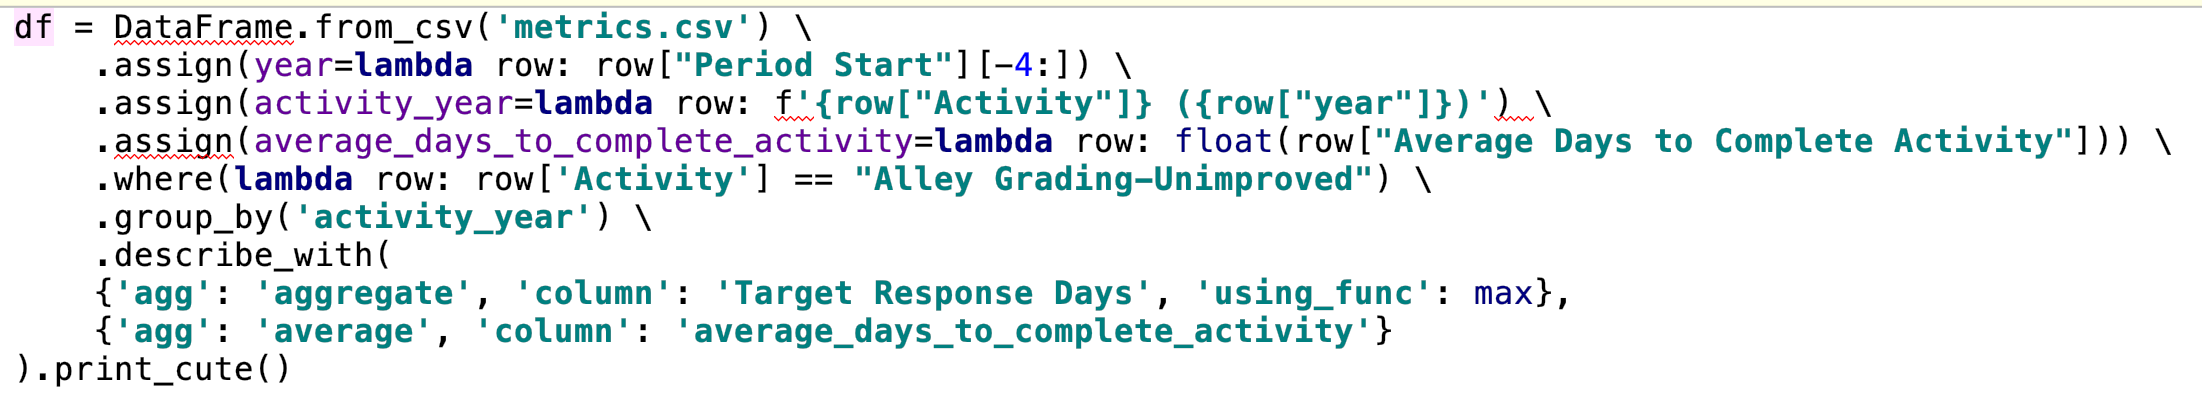

Let's update our `GroupBy` and `DataFrame` objects to allow this! First, we import what we've done so far...

In [ ]:
import csv 
from phoenixcel.dataframe import Series, GroupBy, DataFrame

Now it's time to add some functionality:

In [ ]:
# Subclassing to avoid having to include in this cell
# All the code we already worked on for GroupBy

class GroupBy(GroupBy):
    def describe_with(self, *args):
        descriptions = {}
        for aggregation in args:
            if aggregation['agg'] == 'aggregate':
                result = self.aggregate(on=aggregation['column'], using_func=aggregation['using_func'])
                function_name = aggregation['using_func'].__name__
            else:
                aggregation_function = getattr(self, aggregation['agg'])
                result = aggregation_function(on=aggregation['column'])
                function_name = aggregation['agg']
                
            for result_key in result.keys():
                if not descriptions.get(result_key):
                    descriptions[result_key] = {}
                aggregation_label = f"{aggregation['column']} {function_name}"
                descriptions[result_key][aggregation_label] = result[result_key]                             
        return GroupBy(descriptions)
    
    def print_cute(self):
        '''
        Prints out a GroupBy or a GroupBy Description in a nice format.
        
        Input:
          None - this method operates on the existing GroupBy object.
        
        Output:
          None - no return value
        
        Modifies:
          Prints to standard out with a list of the groups. For each group,
          prints an indented list of the items in it (for a GroupBy), 
          or an indented list of summary statistics (for a Groupby Description).
        '''
        for key, value in self.items():
            print(key)
            
            if isinstance(value, dict):
                for key, component in value.items():
                    print(f"   {key} : {component}")
            else:
                for component in value:
                    print(f"  {component}")

## Challenge:

Write a docstring for `describe_with`. Remember to include:

1. a description of what the method does
2. a list of arguments that it takes in, if it takes in any arguments
3. an explanation of what it returns, if it returns anything
4. an explanation of what it modifies, if it modifies anything

Scroll down to the usage example cell and run/experiment with the code to get a better idea of what this method does!

In [ ]:
# Subclassing to avoid having to include in this cell
# All the code we already worked on for DataFrame

class DataFrame(DataFrame):
    def assign(self, **kwargs):
        for key, value in kwargs.items():
            new_column = Series()
            for row in self._list:
                new_column.append(value(row))
            self.__setitem__(key, new_column)
        return self

## Check out your new code in action:

In [ ]:
df = DataFrame.from_csv('metrics.csv') \
        .assign(year=lambda row: row["Period Start"][-4:]) \
        .assign(activity_year=lambda row: f'{row["Activity"]} ({row["year"]})') \
        .assign(average_days_to_complete_activity=lambda row: float(row["Average Days to Complete Activity"])) \
        .where(lambda row: row['Activity'] == "Alley Grading-Unimproved") \
        .group_by('activity_year') \
        .describe_with(
            {'agg': 'aggregate', 'column': 'Target Response Days', 'using_func': max},
            {'agg': 'average', 'column': 'average_days_to_complete_activity'}
        ).print_cute()

df

## This new functionality is great, but something is off.

Run the block of code below and take a look at the columns of the dataframe after you run that block. Do you notice anything weird about them?

In [ ]:
df = DataFrame.from_csv('metrics.csv') \
        .assign(year=lambda row: row["Period Start"][-4:]) \
        .assign(activity_year=lambda row: f'{row["Activity"]} ({row["year"]})') \
        .assign(average_days_to_complete_activity=lambda row: float(row["Average Days to Complete Activity"])) \
        
df.columns

## Challenge:

Why is the idea of "average days to complete activity" represented in the dataframe twice, in two different string formats?

What is happening in the `assign` code that makes this occur?

If you were an open source maintainer, do you think this is something that you would fix?

If so, how might you fix it? (Feel free to go into the `dataframe.py` file in the `phoenixcel` folder and make changes, but remember that each time you change that file you will need to _restart_ this notebook for the changes to take effect).

## Challenge:

This code is...not especially fast. Try running the below block of code, which does the aggregation on _all_ activity-years rather than by filtering just one kind. There is a noticeable delay between running and finishing:

In [ ]:
df = DataFrame.from_csv('metrics.csv') \
        .assign(year=lambda row: row["Period Start"][-4:]) \
        .assign(activity_year=lambda row: f'{row["Activity"]} ({row["year"]})') \
        .assign(average_days_to_complete_activity=lambda row: float(row["Average Days to Complete Activity"])) \
        .group_by('activity_year') \
        .describe_with(
            {'agg': 'aggregate', 'column': 'Target Response Days', 'using_func': max},
            {'agg': 'average', 'column': 'average_days_to_complete_activity'}
        ).print_cute()

df

Why do you think this is?